## Snake Detection

### 1) Import Needed Modules

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


### 2) Data loading

In [2]:
main_folder = "Snakes Dataset"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['Images with snakes', 'Images without snakes'] 2


In [3]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png") or (file_ext.lower() == "bmp"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 Images with snakes


100%|██████████| 70/70 [00:10<00:00,  6.56it/s]


1 Images without snakes


100%|██████████| 31/31 [00:04<00:00,  6.76it/s]


Total Images Loaded: 707


In [4]:
images = np.array(images)
labels = np.array(labels)

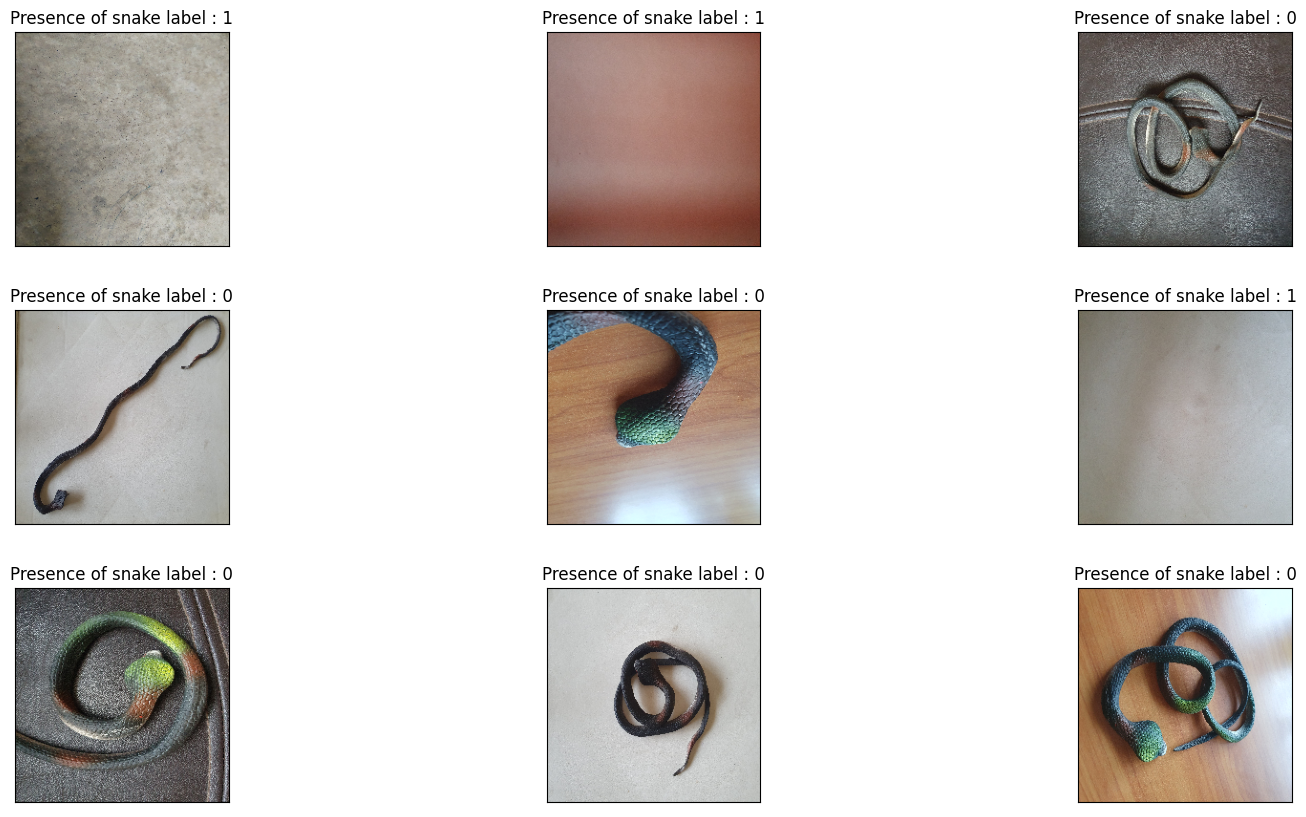

In [5]:
def display_random_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Presence of snake label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_random_images(images, labels)

In [6]:
np.random.seed(RANDOM_SEED)


n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

- Step 2 - Data normalization

In [7]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (707, 224, 224, 3)


- Display few random images after normalization

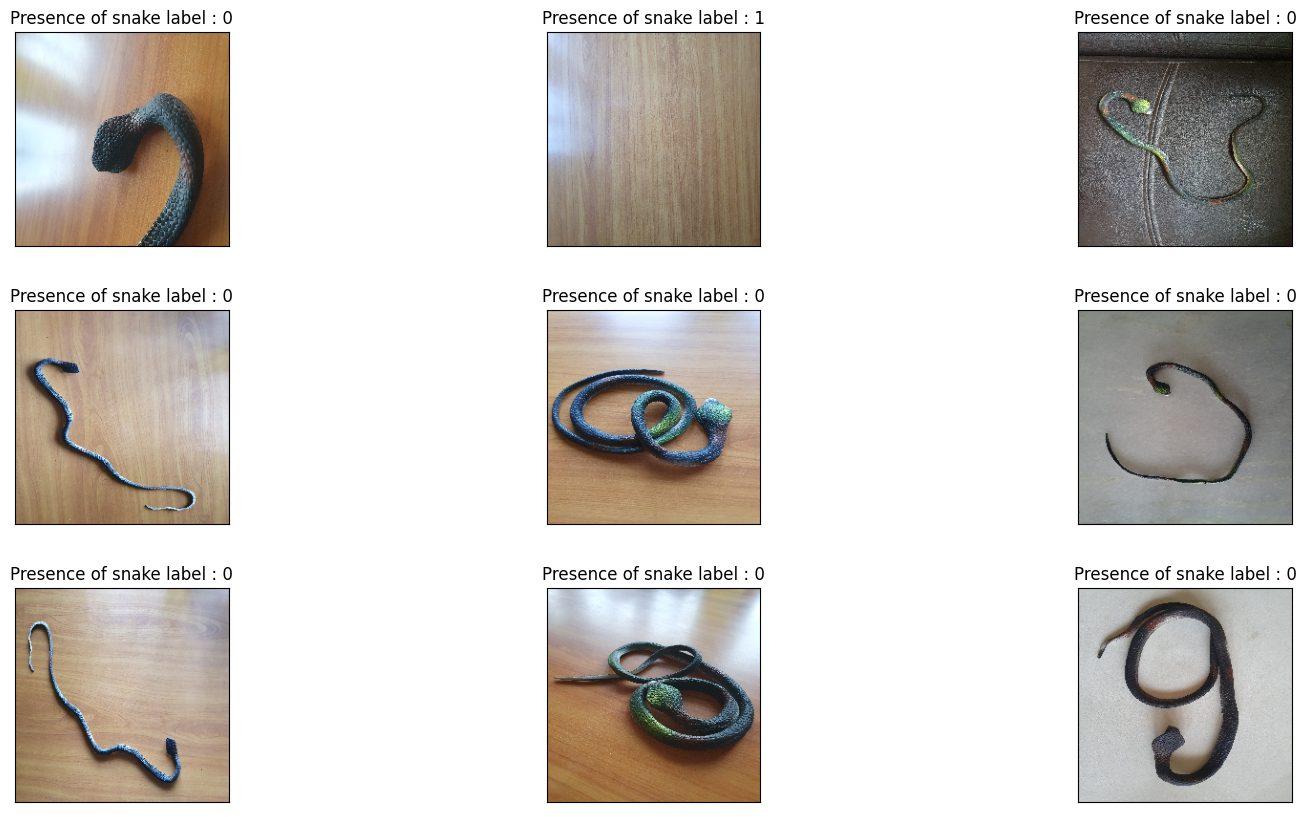

In [8]:
display_random_images(images, labels)

- Split dataset for training and testing

In [9]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (565, 224, 224, 3)
y_train shape =  (565,)

x_test shape =  (142, 224, 224, 3)
y_test shape =  (142,)


In [10]:
del labels
del images

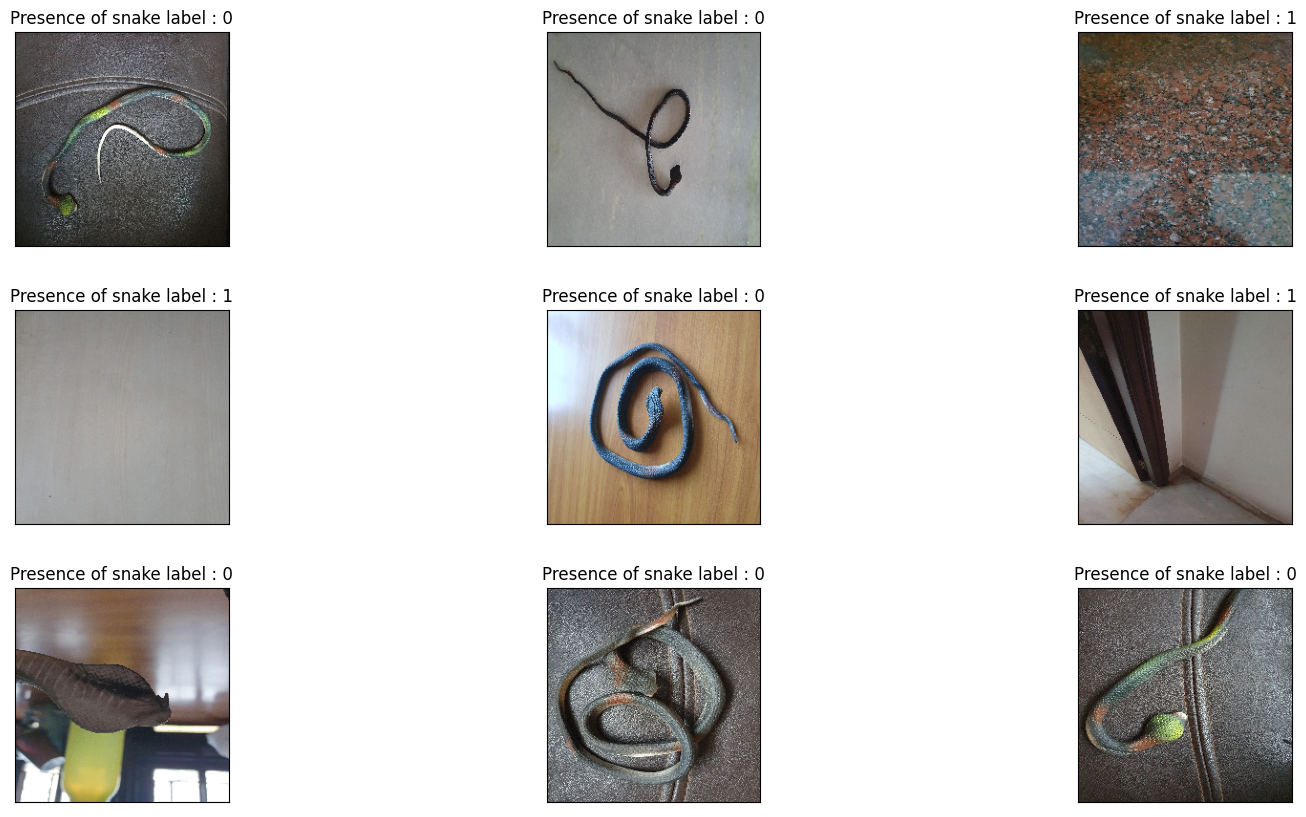

In [11]:
display_random_images(x_train, y_train)

In [12]:
EPOCHS = 10
BATCH_SIZE = 16


# RESNET 50

In [13]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [14]:
#do not train the pre-trained layers of Resnet50
for layer in resnet_50.layers:
    layer.trainable = False

In [15]:
x = Flatten()(resnet_50.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
resnet_50_model.summary()# view the structure of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [17]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

In [18]:
# fit the model
resnet_50_history = resnet_50_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
35/35 [==============================] - 10s 75ms/step - loss: 3.1508 - accuracy: 0.6518 - val_loss: 0.2862 - val_accuracy: 0.8672
Epoch 2/10
35/35 [==============================] - 2s 49ms/step - loss: 0.4930 - accuracy: 0.8452 - val_loss: 0.5285 - val_accuracy: 0.9219
Epoch 3/10
35/35 [==============================] - 2s 45ms/step - loss: 0.4300 - accuracy: 0.8707 - val_loss: 0.3931 - val_accuracy: 0.9219
Epoch 4/10
35/35 [==============================] - 2s 48ms/step - loss: 0.3343 - accuracy: 0.8980 - val_loss: 0.3030 - val_accuracy: 0.9297
Epoch 5/10
35/35 [==============================] - 2s 44ms/step - loss: 0.1730 - accuracy: 0.9308 - val_loss: 0.2244 - val_accuracy: 0.9297
Epoch 6/10
35/35 [==============================] - 2s 44ms/step - loss: 0.1165 - accuracy: 0.9454 - val_loss: 0.1475 - val_accuracy: 0.9297
Epoch 7/10
35/35 [==============================] - 2s 45ms/step - loss: 0.1281 - accuracy: 0.9454 - val_loss: 0.1303 - val_accuracy: 0.9297
Epoch 8/10
3

In [19]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")

5/5 [==============================] - 0s 68ms/step - loss: 0.3135 - accuracy: 0.8873
Resnet_50 Loss: 0.3135294020175934
Resnet_50 Accuracy: 88.73239159584045 %


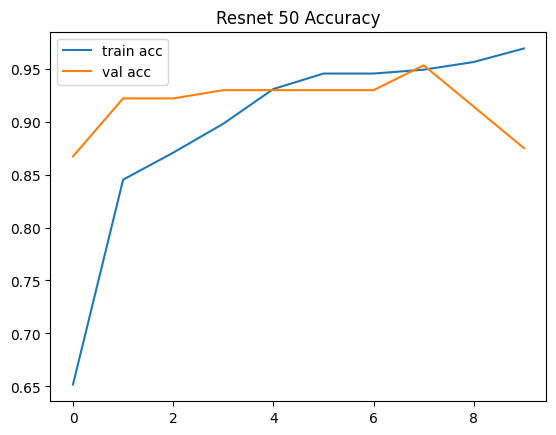

In [20]:
# accuracies
plt.plot(resnet_50_history.history['accuracy'], label='train acc')
plt.plot(resnet_50_history.history['val_accuracy'], label='val acc')
plt.title("Resnet 50 Accuracy")
plt.legend()
plt.show()

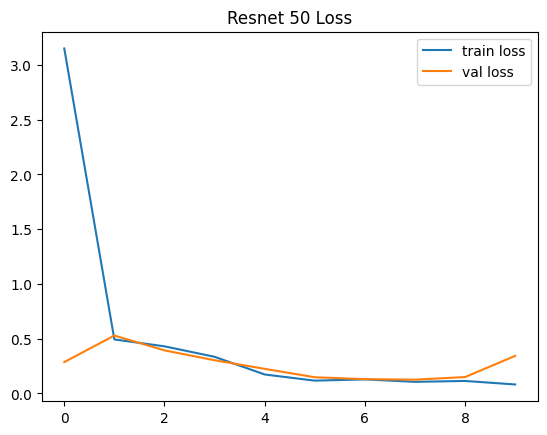

In [21]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 Loss")
plt.legend()
plt.show()

In [22]:
#predict
y_pred=resnet_50_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

5/5 [==============================] - 1s 56ms/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        83
           1       1.00      0.73      0.84        59

    accuracy                           0.89       142
   macro avg       0.92      0.86      0.88       142
weighted avg       0.91      0.89      0.88       142



In [23]:
resnet_50_model.save("Snake_detection_resnet_50_model.h5", save_format="h5")